# Clasificacion de Pistachos

En este trabajo se intentara clasificar la variedad de pistacho a partir de multiples caracteristicas acerca la morfologia y forma de estos. Especificamente las variedades `Siit` y `Kirmizi`.

Los pasos que se seguiran son los siguientes:
1. Preprocesamiento y analisis exploratorio: revisaremos el balanceo de los datos, removeremos dimensiones de estos que no aporten a la clasificacion, removeremos outliers.
1. Analisis exploratorio: realizaremos un analisis breve de las correlaciones entre las variables.
1. Definiremos variables dependientes e independientes, trataremos las variables dummy, separamos los sets de entrenamiento y testeo.
1. Aplicaremos multiples tecnicas de clasificacion, como Regresion Logistica, kNN e intentaremos encontrar la cantidad mas optima de vecinos mas cercanos, Maquina de Soporte Vectorial, Naive Bayes, Arboles de Decision, Random Forest e intentaremos encontrar la cantidad mas optima de arboles de decision.
1. Conclusiones, comparacion de resultados.

El dataset utilizado fue extraido de [Kaggle - pistachio types detection](https://www.kaggle.com/datasets/amirhosseinmirzaie/pistachio-types-detection), aunque no esta claro cual es el origen de este mismo, ya que hay varios sitios web y papers que utilizan identicos datasets por ejemplo: [Kaggle - pistachio image dataset](https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset) o en el paper [Classification of Pistachio Species Using Improved k-NN Classifier](https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178)

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, precision_score, accuracy_score,
    recall_score, f1_score, roc_auc_score, classification_report,
    )
import warnings
warnings.filterwarnings("ignore")

## Revisando el dataset

Las siguientes definiciones de cada feature se pueden encontrar en el paper mencionado anteriormente.
https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178

El dataset a utilizar posee 12 columnas numericas acerca la morfologia de los pistachos:
1. `AREA`: area del pistacho.
2. `PERIMETER`: longitud del borde del pistacho.
3. `MAJOR_AXIS`: longitud del eje que cruza a lo largo del pistacho.
4. `MINOR_AXIS`: longitud del eje que cruza a lo ancho del pistacho.
5. `ECCENTRICITY`: grado de desviacion de una seccion conica con respecto a una circunferencia.
6. `EQDIASQ`: es la relacion `sqrt( 4 * area / pi )`.
7. `SOLIDITY`: es la relacion `area / perimetro`.
8. `CONVEX_AREA`: número de píxeles en el polígono convexo más pequeño que puede contener el área de un pistacho.
9. `EXTENT`: es la relacion `area / area_rectangulo` donde area_rectangulo es el area del rectangulo que contiene al pistacho.
10. `ASPECT_RATIO`: es la relacion `MAJOR_AXIS / MINOR_AXIS`.
11. `ROUNDNESS`: es la relacion `4 * pi * AREA / perimetro**2`.
12. `COMPACTNESS`: es la relacion `EQDIASQ / MAJOR_AXIS`.

Tambien posee 4 columnas numericas acerca de la forma de los pistachos:

13. `SHAPEFACTOR_1`: es la relacion `MAJOR_AXIS / AREA`.
14. `SHAPEFACTOR_2`: es la relacion `MINOR_AXIS / AREA`.
15. `SHAPEFACTOR_3`: es la relacion `AREA / (MAJOR_AXIS/2) * (MAJOR_AXIS/2) * pi`.
16. `SHAPEFACTOR_4`: es la relacion `AREA / (MINOR_AXIS/2) * (MINOR_AXIS/2) * pi`. 

Y una columna categorica:

17. `Class`: variedad de pistacho, puede ser `kirmizi_pistachio` o `siit_pistachio`

A continuacion podemos observar un pistacho con algunas caracteristicas mencionadas:

![pistachio features](./docs/pistachio_features.jpg)

Podemos observar a continuacion como esta compuesto el dataset mas en detalle, como la cantidad de resgistros que tenemos, valores medios, etc:

In [235]:
dataset = pd.read_csv('./content/pistachio.csv')
dataset.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4
count,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000
mean,79871.952852,1421.797588,446.206444,238.193128,0.840347,317.790000,0.940103,84947.671129,0.716055,1.899342,0.570831,0.712841,0.005704,0.003017,0.510097,0.955185
std,12968.217051,373.408835,31.885328,30.426445,0.049026,26.571699,0.050006,13081.742551,0.052534,0.241253,0.211514,0.044230,0.000810,0.000334,0.063391,0.051735
min,29808.000000,858.363000,321.425500,133.509600,0.504900,194.814600,0.588000,37935.000000,0.427200,1.158500,0.062800,0.476000,0.004000,0.002400,0.226600,0.620400
25%,71898.500000,1169.633225,426.554100,217.875475,0.817500,302.562375,0.920250,76357.750000,0.688100,1.736325,0.372325,0.682000,0.005200,0.002800,0.465125,0.944200
50%,79795.000000,1260.785500,448.453150,235.888750,0.850250,318.744650,0.953800,84973.000000,0.726100,1.899550,0.643850,0.709750,0.005600,0.003000,0.503750,0.972800
75%,88980.000000,1599.479000,467.515200,257.433625,0.875375,336.590000,0.976300,93660.750000,0.753600,2.068575,0.744450,0.741600,0.006100,0.003200,0.549975,0.986800
max,124008.000000,2755.049100,535.642200,383.046100,0.946000,397.356100,0.995100,132478.000000,0.820400,3.085800,0.933600,0.869500,0.013100,0.005300,0.756100,0.999000


## Preprocesado de datos y Analisis Exploratorio

A continuacion analizaremos el dataset para ver si es necesario realizar algun tipo de preprocesamiento para eliminar outliers o balancear el dataset, tambien analizaremos que correlaciones podemos encontrar entre las variables.

### Balanceo de datos

Empezemos analizando cuantos datos tenemos de cada clase de pistacho, esto es importante para saber si debemos balancear el dataset o no.

De no estar balanceado el dataset, podriamos tener problemas a la hora de entrenar los modelos, ya que podrian aprender a clasificar solo una clase y no la otra.

Ademas de esto, podria ocasionar que obtengamos una precision erronea, ya que si tenemos 90% de pistachos A y 10% de pistachos B, un modelo que siempre clasifique a todos por A tendria un 90% de precision, pero no seria un buen modelo.

([<matplotlib.patches.Wedge at 0x7fef58744b20>,
 [Text(-0.2765972019687502, 1.0646567464976957, 'Kirmizi'),
  Text(0.2765973016491072, -1.064656720600792, 'Siit')],
 [Text(-0.15087120107386373, 0.5807218617260157, '58.1%'),
  Text(0.15087125544496752, -0.580721847600432, '41.9%')])

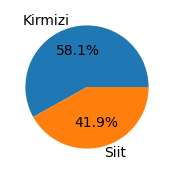

In [236]:
plt.figure(figsize = (2, 2))
plt.pie(
    dataset['Class'].value_counts(),
    labels=['Kirmizi', 'Siit'],
    autopct='%1.1f%%',
    )

Podemos observar que la cantidad de pistachos de cada clase es mas o menos similar, cercanos al 50% de cada variedad, por lo cual no es necesario balancear el dataset.

### Distribucion de los datos

A continuacion procederemos a observar la distribucion de los datos, esto puede sernos de utilidad para:
1. Nos da un primer vistazo de como se pueden clasificar ambas categorias de pistachios.
1. Saber si los datos estan normalmente distribuidos o no, importante para decidir si aplicar `Desviacion Estandar` y `Z-Score` o `Rango intercuartilico (IQR)` y `Percentil` en caso de que no lo esten, para remover outliers.
1. Seleccionar las variables donde mas se diferencian ambas categorias. 

Antes de continuar, vale aclarar que una distribucion normal ideal, tambien llamada Campana de Gauss tiene la siguiente forma:

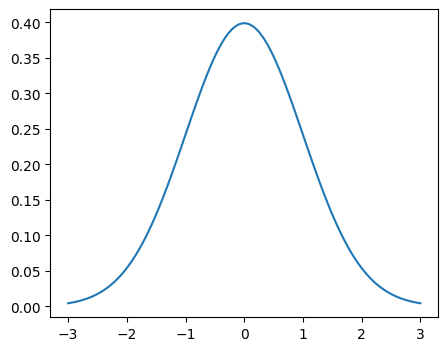

In [237]:
# https://stackoverflow.com/a/10138308/15648632
mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y = stats.norm.pdf(x, mu, sigma)
fig = plt.figure(figsize=(5, 4))
plt.plot(x, y)
plt.show()

Aclarado esto, continuamos con el ploteado de las distribuciones de los datos:

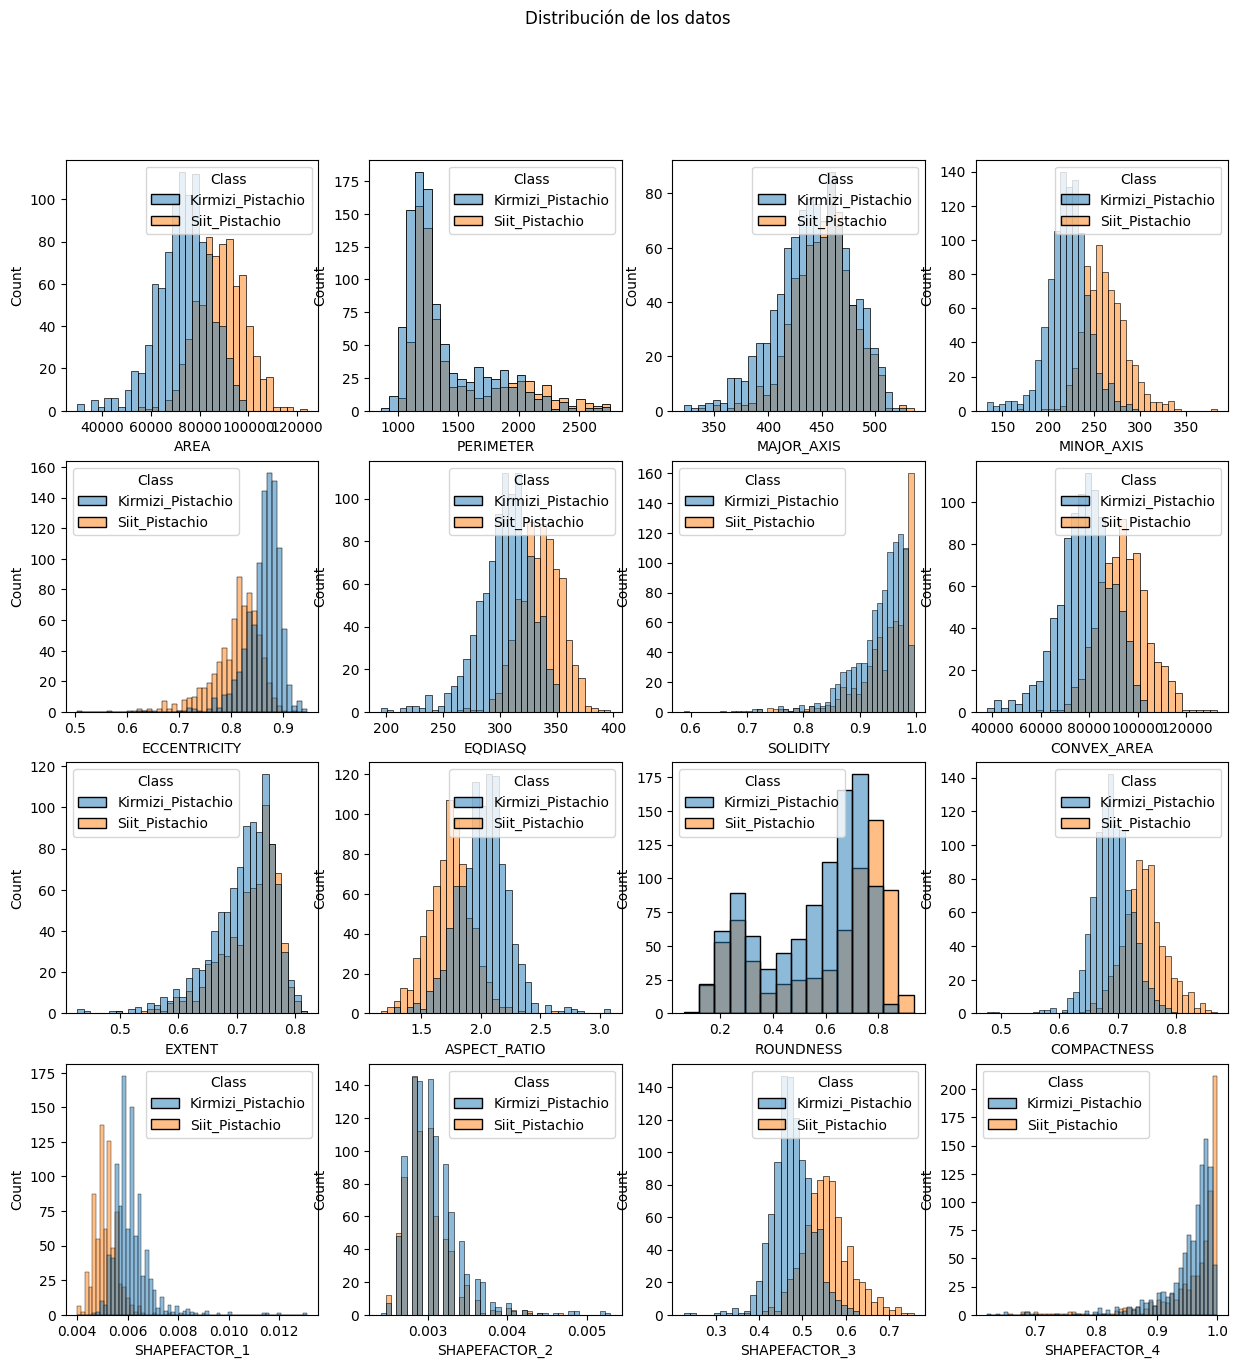

In [238]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle('Distribución de los datos')
for i, column in enumerate(dataset.columns[:-1]):
    sns.histplot(
        data=dataset,
        x=column,
        hue='Class',
        ax=ax[i//4][i%4],
    )
plt.show()

En la mayoria de las variables, como por ejemplo en `AREA`, `CONVEX_AREA`, `ECCENTRICITY`, `SHAPEFACTOR_3` y otras, se observa que:
1. Efectivamenta los datos estan normalmente distribuidos.
1. Se forman dos Campanas de Gauss, una para cada categoria, si separamos ambas categorias tendriamos dos valores medios en cada variable, se debe tener en cuenta esto para la limpieza de los outliers.

Tambien se puede observar que los datos en las variables `PERIMETER`, `MAJOR_AXIS`, `SOLIDITY`, `EXTENT`, `ROUNDNESS`, `SHAPEFACTOR_2`, `SHAPEFACTOR_4` tienen una distribucion similar entre ambas categorias, podemos proceder a eliminar estas variables para simplifar el modelo.

In [239]:
columnas_a_remover = [
    'PERIMETER', 'MAJOR_AXIS', 'SOLIDITY',
    'EXTENT', 'ROUNDNESS', 'SHAPEFACTOR_2',
    'SHAPEFACTOR_4',
]
dataset = dataset.drop(columns=columnas_a_remover)

Vemos que columnas quedaron finalmente

In [240]:
for col in dataset.columns:
    print(col)

AREA
MINOR_AXIS
ECCENTRICITY
EQDIASQ
CONVEX_AREA
ASPECT_RATIO
COMPACTNESS
SHAPEFACTOR_1
SHAPEFACTOR_3
Class


### Deteccion de outliers

Procederemos a analizar si existen outliers y de ser asi, eliminarlos ya que tener valores anormalmente altos o anormalmente bajos podrian afectar en el entendimiento de los datos y afectar al entrenamiento de los modelos.

Ya que los datos estan normalmente distribuidos, aplicaremos el metodo de `Desviacion Estandar` y `Z-Score`.

La `Desviacion Estandar` es una medida que se utiliza para cuantificar la variación o la dispersión de un conjunto de datos numéricos, una desviacion baja indica que los datos estan muy cerca de la media y una desviacion alta indica que los datos estan mas dispersos y alejados de la media.

El `Z-Score` es el numero de desviaciones estandar de un valor en relacion con la media, puede ser desde -3 hasta +3.

Procedemos a remover los outliers con `Z-Score`, por lo anteriormente mencionado acerca las campanas de Gauss en cada categoria, deberemos separar los datos en dos grupos antes de remover los outliers.

In [241]:
kirmizi = dataset[dataset['Class'] == 'Kirmizi_Pistachio']
siit = dataset[dataset['Class'] == 'Siit_Pistachio']

In [242]:
def limpiar_outliers_zscore(df: pd.DataFrame) -> pd.DataFrame:
    threshold = 3
    for column in df.columns[:-1]:
        zscore = np.abs(stats.zscore(df[column]))
        df[column] = np.where(zscore > threshold, np.nan, df[column])
    return df.dropna()
kirmizi = limpiar_outliers_zscore(kirmizi)
siit = limpiar_outliers_zscore(siit)

In [243]:
cantidad_inicial = len(dataset)
dataset = pd.concat([kirmizi, siit])
cantidad_final = len(dataset)

Veamos cuantos outliers fueron removidos en total:

In [244]:
porcentaje_removido = (cantidad_inicial - cantidad_final) / cantidad_inicial * 100
print(f'Cantidad de datos removidos: {cantidad_inicial - cantidad_final} ({porcentaje_removido:.2f}%)')

Cantidad de datos removidos: 58 (3.38%)


## Correlaciones

Ahora procederemos a analizar las correlaciones entre variables, para observar si efectivamente se pueden separar los datos en dos categorias, para esto es necesario que formen dos "nubes" de datos que esten bien diferenciados entre si.

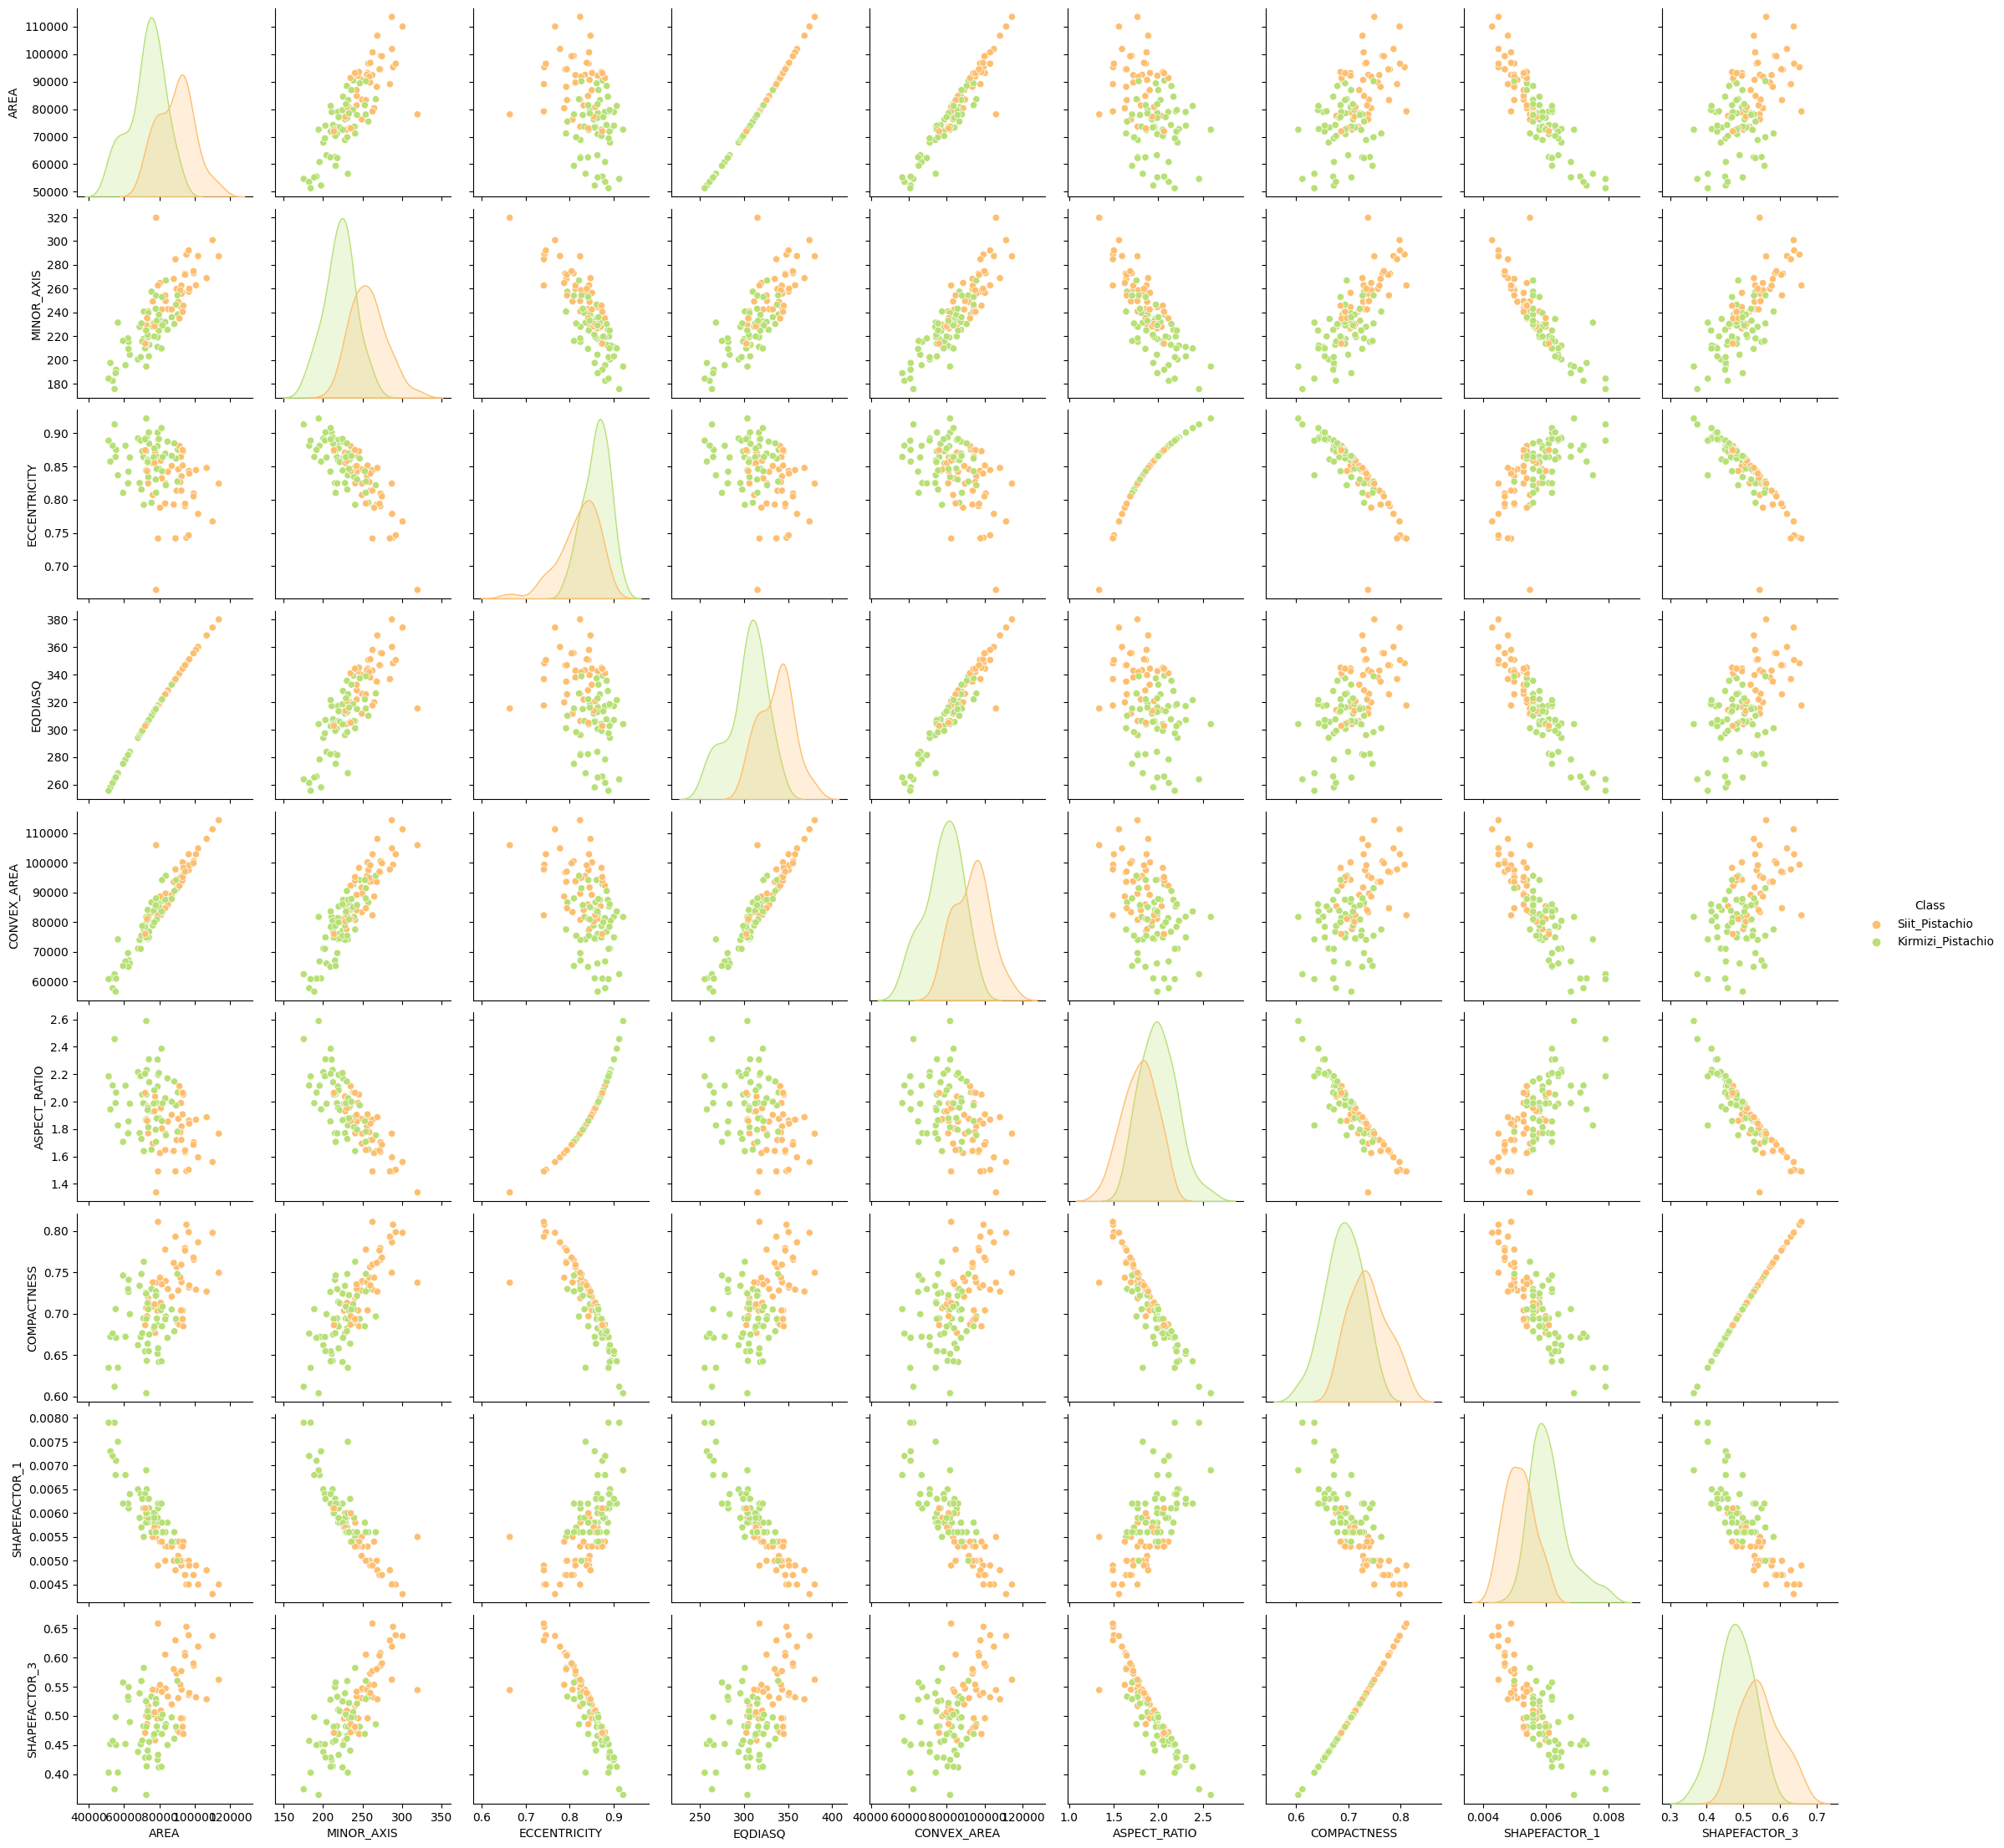

In [245]:
columnas = [
    'AREA', 'MINOR_AXIS', 'ECCENTRICITY',
    'EQDIASQ', 'CONVEX_AREA', 'ASPECT_RATIO',
    'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_3',
]
sns.pairplot(
    dataset.sample(100),
    hue='Class',
    vars=columnas,
    palette='RdYlGn',
    )
plt.show()

Podemos observar que efectivamente las categorias de Pistachos se agrupan en "nubes" de datos, lo que significa que podemos separarlos en dos categorias.

### Definiendo las variables dependientes e independientes

Ahora pasaremos a definir que variables usaremos como input `X` y cuales como output `y` (la que deseamos predecir) en los modelos.

Como variable independiente X utilizaremos las 9 columnas numericas que diferencian a los pistachos:

In [246]:
X = dataset.iloc[:, :9].values
X

array([[7.310700e+04, 2.177261e+02, 8.705000e-01, ..., 6.896000e-01,
        6.100000e-03, 4.756000e-01],
       [6.095500e+04, 2.091255e+02, 8.414000e-01, ..., 7.200000e-01,
        6.300000e-03, 5.184000e-01],
       [7.953700e+04, 2.212136e+02, 8.806000e-01, ..., 6.817000e-01,
        5.900000e-03, 4.648000e-01],
       ...,
       [8.480800e+04, 2.358735e+02, 8.728000e-01, ..., 6.799000e-01,
        5.700000e-03, 4.623000e-01],
       [9.027000e+04, 2.698232e+02, 7.774000e-01, ..., 7.903000e-01,
        4.800000e-03, 6.246000e-01],
       [7.878000e+04, 2.393016e+02, 8.481000e-01, ..., 7.013000e-01,
        5.700000e-03, 4.919000e-01]])

Antes de determinar la variable dependiente Y, que es la que necesitaremos predecir, vamos a convertir las variables categoricas `Class` en variables ficticias, basicamente creariamos una columna nueva para cada categoria con `1s` y `0s`.

In [247]:
df_class = pd.get_dummies(dataset['Class'])
df_class.sample(5)

,Kirmizi_Pistachio,Siit_Pistachio
780,0,1
268,1,0
814,1,0
849,1,0
1568,1,0


In [248]:
dataset = pd.concat([dataset, df_class], axis=1)

Finalmente utilizaremos como variable Y la columna `Kirmizi_Pistachio`:

In [249]:
y = dataset['Kirmizi_Pistachio'].values
y

array([1, 1, 1, ..., 0, 0, 0], dtype=uint8)

### Separando datos de entrenamiento y testeo

Separamos los datos en sets para utilizar un porcentaje para el entrenamiento y otro para el testeo del modelo.

In [250]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 0,
    )

Como ultimo paso en esta etapa vamos estandarizar y escalar los datos

In [251]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_train, X_test

(array([[-0.27028772, -0.20474649,  0.07726659, ...,  0.14441467,
          0.03937123,  0.11452702],
        [ 0.96837084,  1.60481555, -2.49937583, ...,  2.62265659,
         -1.74307153,  2.75905748],
        [ 0.22731017, -0.59565202,  1.06141715, ..., -0.9334006 ,
          0.18790812, -0.92530439],
        ...,
        [ 2.20110959,  1.12599257,  0.10075467, ...,  0.36193295,
         -1.29746084,  0.33334962],
        [-0.65766034, -1.41217797,  1.4842026 , ..., -1.64705606,
          1.2276664 , -1.57837959],
        [ 0.80820235,  0.11193761,  0.65507336, ..., -0.55457664,
         -0.25770257, -0.56738526]]),
 array([[ 1.1846525 ,  1.22713664, -1.16760167, ...,  1.57416962,
         -1.44599774,  1.59878882],
        [-1.51503285, -0.38269015, -0.31263555, ..., -0.53013638,
          1.37620329, -0.54533337],
        [ 0.57432801,  0.22501199,  0.51179607, ..., -0.67188986,
         -0.10916567, -0.67934101],
        ...,
        [ 0.28550778,  0.0191202 ,  0.10545228, ...,  

## Clasificacion con Regresion Logistica

Este metodo de clasificacion basicamente intenta predecir con reglas de la probabilidad que tan probable es que haya un fallo o no, utilizando una funcion sigmoide.

Definimos el modelo y lo entrenamos

In [252]:
classifier = LogisticRegression(
    random_state = 0,
    )
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

Realizamos predicciones a partir de los datos de testeo

In [253]:
y_pred = classifier.predict(X_test)

Podemos observar en la matriz de confusion que se obtuvo una buena cantidad de aciertos para ambas categorias

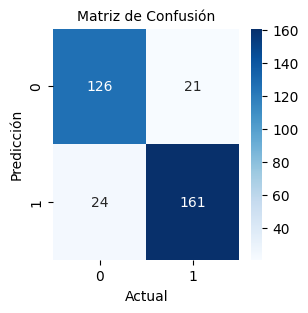

In [254]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (3, 3))
    sns.heatmap(
        cm,
        annot=True,
        fmt='g',
        cmap='Blues',
        )
    plt.ylabel('Predicción', fontsize=10)
    plt.xlabel('Actual', fontsize=10)
    plt.title('Matriz de Confusión', fontsize=10)
    plt.show()
#
plot_confusion_matrix(y_test, y_pred)

A continuacion podemos observar con mayor detalle las diferentes metricas obtenidas con el modelo:
- `Exactitud`: se calcula haciendo la sumatoria del error entre el valor real y la prediccion, dividido por la cantidad de datos, nos indica que tan cerca esta el modelo de la prediccion correcta, en un rango del 0 al 1.
- `Precision`: su formula es `tp/(tp+fp)` donde `tp` son los verdaderos positivos y `fp` los falsos positivos, nos indica en un rango del 0 al 1 que tan bien clasifica el modelo a los verdaderos positivos.
- `Recall`: similar a la `Precision`, pero tomando en cuenta los falsos negativos, su formula es `tp / (tp + fn)`.
- `Puntaje F1`: a diferencia de las anteriores, este puntaje nos indica que tan bien clasifica el modelo a los verdaderos positivos y a los falsos negativos, ya que es la media armonica entre `Precision` y `Recall`, su formula es `2 * (precision * recall) / (precision + recall)`.
- `ROC-AUC`: es el area bajo la curva `ROC`, la curva ROC es la grafica del ratio de positivos verdaderos y el ratio de falsos positivos.

In [255]:
def obtener_metricas_df(nombre_modelo, y_test, y_pred) -> pd.DataFrame:
    return pd.DataFrame({
        'Modelo': [nombre_modelo],
        'Exactitud': [accuracy_score(y_test, y_pred)],
        'Precisión': [precision_score(y_test, y_pred)],
        'Recall': [recall_score(y_test, y_pred)],
        'Sensibilidad': [recall_score(y_test, y_pred)],
        'Puntaje F1': [f1_score(y_test, y_pred)],
        'ROC-AUC': [roc_auc_score(y_test, y_pred)],
    })
#
rl_metricas_df = obtener_metricas_df('Regresion Logistica', y_test, y_pred)
rl_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,Regresion Logistica,0.864458,0.884615,0.87027,0.87027,0.877384,0.863707


Los resultados de las metricas obtenidas con los modelos las vamos a ir acumulando para luego compararlas a final del trabajo

In [256]:
metricas_df = pd.DataFrame()
metricas_df = pd.concat([metricas_df, rl_metricas_df])

## Clasificacion con K vecinos mas cercanos (kNN)

Basicamente este metodo de clasificacion intenta predecir si un punto de un dato pertenece a una categoria u otra, basandose en que tan cercanos son a otros puntos de datos, en caso de que un dato este rodeado por diferentes categorias, se realiza una votacion de mayoria.

Para poder encontrar la cantidad optima de vecinos cercanos a tener en cuenta, definiremos una funcion para definir y entrenar el modelo a la que le ingresamos una cantidad de vecinos cercanos a utilizar

In [257]:
def knn_classifier(cantidad_vecinos:int):
    model = KNeighborsClassifier(
        n_neighbors = cantidad_vecinos,
        metric = "minkowski",
        p = 2,
        )
    model.fit(X_train, y_train)
    return model

Utilizamos esta funcion para crear modelos de kNN con desde 1 hasta 50 vecinos mas cercanos y ploteamos las metricas obtenidas para cada modelo

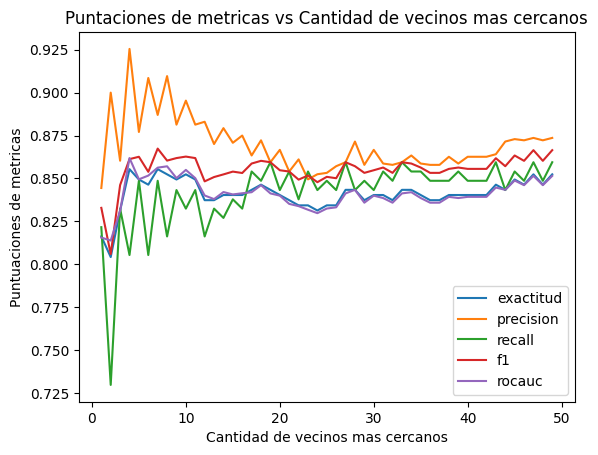

In [258]:
def setup_plot_linea_metricas(model_y_func, max_x:int):
    """Grafico de lineas de las metricas, segun una cantidad x"""
    x = [ i for i in range(1, max_x, 1) ]
    y_acc = []
    y_pre = []
    y_rec = []
    y_f1 = []
    y_rocauc = []
    #
    for i in x:
        y_pred = model_y_func(i).predict(X_test)
        y_acc.append(accuracy_score(y_test, y_pred))
        y_pre.append(precision_score(y_test, y_pred))
        y_rec.append(recall_score(y_test, y_pred))
        y_f1.append(f1_score(y_test, y_pred))
        y_rocauc.append(roc_auc_score(y_test, y_pred))
    #
    plt.plot(x, y_acc, label = 'exactitud')
    plt.plot(x, y_pre, label = 'precision')
    plt.plot(x, y_rec, label = 'recall')
    plt.plot(x, y_f1, label = 'f1')
    plt.plot(x, y_rocauc, label = 'rocauc')
    plt.legend()
#
setup_plot_linea_metricas(knn_classifier, 50)
plt.xlabel("Cantidad de vecinos mas cercanos")
plt.ylabel("Puntuaciones de metricas")
plt.title('Puntaciones de metricas vs Cantidad de vecinos mas cercanos')
plt.show()

Podemos observar que mejor la metrica `f1` lo conseguimos con 5 vecinos mas cercanos, por lo que utilizaremos este valor para el modelo final de kNN.

In [259]:
classifier = knn_classifier(5)
y_pred = classifier.predict(X_test)

Veamos la matrix de confusion resultante utilizando el modelo de kNN con la mas optima cantidad de vecinos cercanos

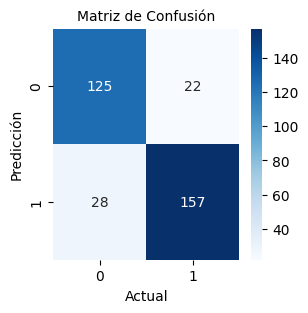

In [260]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver que tuvo una buena cantidad de aciertos para ambas categorias

A continuacion podemos observar con mayor detalle las diferentes metricas obtenidas con el modelo

In [261]:
knn_metricas_df = obtener_metricas_df('kNN', y_test, y_pred)
knn_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,kNN,0.849398,0.877095,0.848649,0.848649,0.862637,0.849494


In [262]:
metricas_df = pd.concat([metricas_df, knn_metricas_df])

## Clasificacion con Maquina de Soporte Vectorial

Basicamente este metodo de clasificacion intenta predecir una categoria, separando los datos con hiperplanos, el negativo y positivo que son los mas cercanos a los datos y el hiperplano optimo que es el intermedio entre ambos.

Definimos el modelo y lo entrenamos

In [263]:
classifier = SVC(
    kernel = "rbf",
    random_state = 0,
    )
classifier.fit(X_train, y_train)

SVC(random_state=0)

Realizamos las predicciones de testeo

In [264]:
y_pred = classifier.predict(X_test)

Podemos ver que obtuvimos una buena cantidad de aciertos para ambas categorias, lo que indica que el modelo es bueno

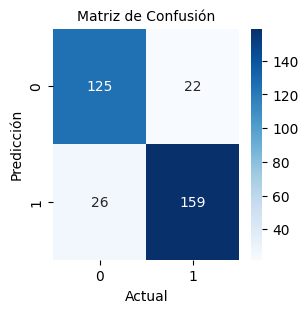

In [265]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver con mayor detalle las diferentes metricas obtenidas con el modelo:

In [266]:
msv_metricas_df = obtener_metricas_df('MSV', y_test, y_pred)
msv_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,MSV,0.855422,0.878453,0.859459,0.859459,0.868852,0.8549


In [267]:
metricas_df = pd.concat([metricas_df, msv_metricas_df])

## Clasificacion con Naive Bayes

Basicamente este metodo de clasificacion utiliza el Teorema de Bayes, el cual intenta predecir cual es la probabilidad de que un evento ocurra comparando las caracteristicas de este evento vs la probabilidad de que ocurra un evento similar.

Definimos el modelo y lo entrenamos

In [268]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB()

Realizamos las predicciones de testeo

In [269]:
y_pred = classifier.predict(X_test)

Podemos ver que el modelo es bueno ya que obtuvimos una buena cantidad de aciertos para ambas categorias

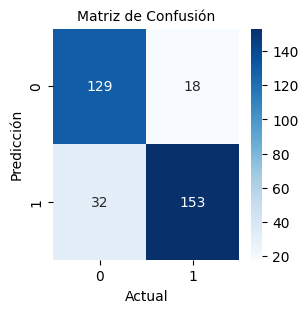

In [270]:
plot_confusion_matrix(y_test, y_pred)

Podemos ver con mayor detalle las diferentes metricas obtenidas con el modelo:

In [271]:
nb_metricas_df = obtener_metricas_df('Naive Beyes', y_test, y_pred)
nb_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,Naive Beyes,0.849398,0.894737,0.827027,0.827027,0.859551,0.852289


In [272]:
metricas_df = pd.concat([metricas_df, nb_metricas_df])

## Clasificacion con Arboles de Decision

Este metodo de clasificacion funciona subdividiendo los datos siguiendo el criterio seleccionado, estas subdivisiones se realizan recursivamente por lo que van formando una estructura de arbol.

Los criterios utilizados en estos modelos basicamente intentan medir la frecuencia con la que un elemento del dataset puede ser mal clasificado cuando es seleccionado aleatoriamente. Puede utilizarse `Entropia` o la `impureza de Gini`.

Definimos el modelo y lo entrenamos, en este caso utilizando el criterio de entropia

In [273]:
classifier = DecisionTreeClassifier(
    criterion = "entropy",
    random_state = 0,
    )
classifier.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Realizamos las predicciones de testeo

In [274]:
y_pred = classifier.predict(X_test)

Podemos ver que el modelo es muy bueno ya que obtuvimos una buena cantidad de aciertos para ambas categorias

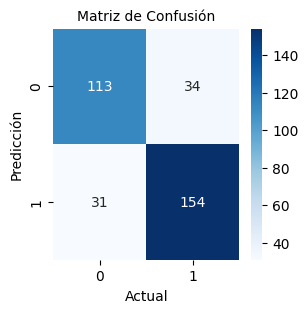

In [275]:
plot_confusion_matrix(y_test, y_pred)

Vemos en detalle las diferentes metricas obtenidas con el modelo:

In [276]:
arboles_metricas_df = obtener_metricas_df('Arboles de Decision', y_test, y_pred)
arboles_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,Arboles de Decision,0.804217,0.819149,0.832432,0.832432,0.825737,0.80057


In [277]:
metricas_df = pd.concat([metricas_df, arboles_metricas_df])

## Clasificacion con Random Forest

Basicamente este metodo combina multiples arboles de decision en un mismo resultado mediante votacion, obteniendo metricas mejpres que cada uno de los arboles individualmente. Este tipo de metodos que combinan multiples modelos se denominan [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning).

Basicamente el Random Forest logra obtener un rendimiento mejor que un arbol de decision individual, debido a que si aumentamos la complejidad de este ultimo para tener un mejor resultado, obtendremos un overfitting que no es deseado, en cambio combinando multiples arboles simples, podemos obtener mejores resultados sin aumentar la complejidad de cada arbol individualmente.

Al igual que con kNN, vamos a crear un modelo con una cantidad de arboles de decision desde 1 hasta 100 para ver cual es la cantidad optima de estimadores a utilizar

In [278]:
def rf_classifier(cantidad_arboles):
    model = RandomForestClassifier(
        n_estimators = cantidad_arboles,
        criterion = "entropy",
        random_state = 0,
        )
    model.fit(X_train, y_train)
    return model

Procedemos a hacer las estimaciones y plotear las metricas con cada modelo de random forest (RF)

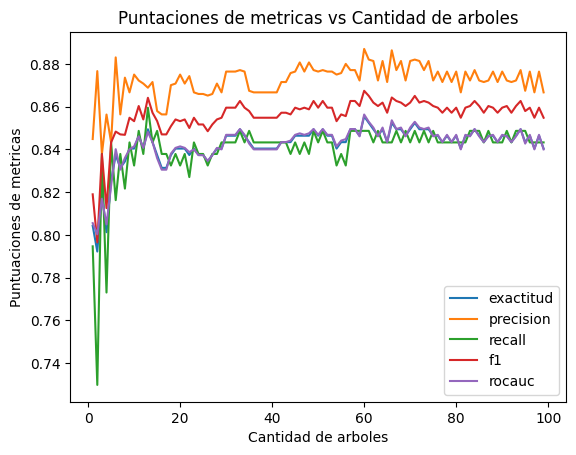

In [279]:
setup_plot_linea_metricas(rf_classifier, 100)
plt.xlabel("Cantidad de arboles")
plt.ylabel("Puntuaciones de metricas")
plt.title('Puntaciones de metricas vs Cantidad de arboles')
plt.show()

Podemos observar como mejoran drastricamente las metricas en un principio, pero luego de los 15 estimadores, se empieza a mantener estables, lo que significa que no es necesario utilizar mas que esta cantidad de arboles.

In [280]:
classifier = rf_classifier(15)

Realizamos nuevamente las predicciones con el ultimo modelo

In [281]:
y_pred = classifier.predict(X_test)

Procedemos analizar la matriz de confusion para ver la cantidad de aciertos obtenidos con la optima cantidad de arboles

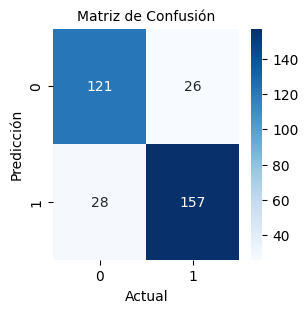

In [282]:
plot_confusion_matrix(y_test, y_pred)

Vemos en detalle las metricas obtenidas con el ultimo modelo:

In [283]:
rf_metricas_df = obtener_metricas_df('Random Forest', y_test, y_pred)
rf_metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,Random Forest,0.837349,0.857923,0.848649,0.848649,0.853261,0.835889


In [284]:
metricas_df = pd.concat([metricas_df, rf_metricas_df])

## Conclusiones

Finalmente hemos logrado poder clasificar con exito el tipo de pistacho utilizando los metodos de clasificacion `Regresion Logistica`, `kNN`, `Maquina de Soporte Vectorial`, `Naive Bayes`, `Arboles de Decision` y `Random Forest` obteniendo muy buenos resultados en general.

Podemos decir que el mejor modelo para este problema especifico fue el de `Regresion Logistica` ya que obtuvo un `puntaje F1` de `0.87`, tenemos en cuenta esta metrica de entre todas, ya que esta toma en consideracion tanto la Precision como el Recall.

Tambien podemos decir que la seleccion de caracteristicas inicial fue muy buena ya que obtuvimos muy buenos resultados de todas maneras.

In [285]:
metricas_df

,Modelo,Exactitud,Precisión,Recall,Sensibilidad,Puntaje F1,ROC-AUC
0,Regresion Logistica,0.864458,0.884615,0.870270,0.870270,0.877384,0.863707
0,kNN,0.849398,0.877095,0.848649,0.848649,0.862637,0.849494
0,MSV,0.855422,0.878453,0.859459,0.859459,0.868852,0.854900
0,Naive Beyes,0.849398,0.894737,0.827027,0.827027,0.859551,0.852289
0,Arboles de Decision,0.804217,0.819149,0.832432,0.832432,0.825737,0.800570
0,Random Forest,0.837349,0.857923,0.848649,0.848649,0.853261,0.835889


## Referencias

Paper - clasificacion de pistachios con kNN: https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178

Kaggle - pistachio types detection: https://www.kaggle.com/datasets/amirhosseinmirzaie/pistachio-types-detection

Kaggle - pistachio image dataset: https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset